In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from keras.datasets import mnist
from collections import namedtuple
import networkx as nx
import random
import itertools

In [ ]:
class Node:
  def __init__(self, id, value, is_factor, is_observed):
    '''
    1. create a node
    :param id: the node id (e.g. x1)
    :param is_factor: a boolean variable, true: is factor; false: is node
    :param is_observed: a boolean variable, true: is observed; false: is unobserved
    :return:
    '''
    self.id = id
    self.value = value
    self.is_factor_node = is_factor
    self.is_observed = is_observed
    self.outgoing_edges = []
    self.incoming_edges = []

  def __hash__(self):
    return hash(self.id)

  def __eq__(self, other):
    return self.id == other.id

  def __str__(self):
    return self.id

In [ ]:
class Edge:
  def __init__(self, from_node, to_node):
    '''
    1. create a edge with direction(from_node -> to_node)
    2. each directed edge corresponds to one message(each iteration), it means the message sent by the 
    edge origin node to the edge end node; they are stored in list messgaes[]
    
    :param from_node: the origin node of this edge
    :param to_node: the end node of this edge  
    '''
    self.from_node = from_node
    self.to_node = to_node
    self.messages = torch.ones([1,2])


  def __hash__(self):
    return hash(self.from_node + self.to_node)

  def __eq__(self, other):
    return (self.from_node, self.to_node) == (other.from_node, other.to_node)

  def __str__(self):
    return str(self.from_node) + "-->" + str(self.to_node)

In [ ]:
class Graph:

  def __init__(self, graph_map, value_map, hidden_list):
    '''
    create a graph according to the graph_map and observed_list
    :param graph_map: the dictionary of graph
    :param value_map: the dictionary of observed values
    :param hidden_list: a list which contains all unobserved nodes
    :return:
    '''
    nodes = []
    self.graph_map = graph_map
    self.value_map = value_map
    self.hidden_list = hidden_list
                            
    # create the graph
    self.nodes = {}
    self.edges = {}
    for node, _ in self.graph_map.items():
      n = None
      if node.startswith("x"):
        if node in hidden_list:
          n = Node(node, None, False, False)
        else:
          n = Node(node, value_map[node], False, True)
      elif node.startswith("f"):
        n = Node(node, None, True, None)
      self.nodes[n.id] = n
    for node, connections in self.graph_map.items():
      n = self.nodes[node]
      for connection in connections:
        edge = None
        if self.nodes.get(connection):
          edge = Edge(n, self.nodes[connection])
        n.outgoing_edges.append(edge)
        self.nodes[connection].incoming_edges.append(edge)
        self.edges[str(edge)] = edge

  def __str__(self):
    result = ""
    for id, node in self.nodes.items():
      result += str(node) + " (" + str(node.is_factor_node) + ") :\n"
      for edge in node.outgoing_edges:
        result += str(edge) + "\n"
      result += "\n"
    return result

In [ ]:
def create_graphMap(graph_size=28):
  '''
  create a dictionary, the key is each node/factor, the values are its neighbers
  :param graph_size: the length of the graph(MNIST: 28)
  :return: the dictionary
  '''
  map = {}
  index=0
  for i in range(graph_size):
    for j in range(graph_size):
      index += 1
      map['x{}'.format(index)] = []
      if i>0:
        if j>0:
          map['x{}'.format(index)].append('f{}'.format((i-1)*(graph_size-1)+j))
        if j<27:
          map['x{}'.format(index)].append('f{}'.format((i-1)*(graph_size-1)+j+1))
      if i<27:
        if j>0:
          map['x{}'.format(index)].append('f{}'.format(i*(graph_size-1)+j))
        if j<27:
          map['x{}'.format(index)].append('f{}'.format(i*(graph_size-1)+j+1))
  # for item in map:
  #   print(item,":",map[item])
  index=0
  for i in range(graph_size-1):
    for j in range(graph_size-1):
      index += 1
      map['f{}'.format(index)] = []
      map['f{}'.format(index)].append('x{}'.format(i*graph_size+j+1))
      map['f{}'.format(index)].append('x{}'.format(i*graph_size+j+1+1))
      map['f{}'.format(index)].append('x{}'.format((i+1)*graph_size+j+1))
      map['f{}'.format(index)].append('x{}'.format((i+1)*graph_size+j+1+1))
  # for item in map:
  #   print(item,":",map[item])
  return map

def create_valueMap(image, re_list, image_size=28):
  '''
  create a dictionary:
  the key is each observed node;
  the value is the corresponding value in the training image
  '''
  index = 0
  map = {}
  for i in range(image_size):
    for j in range(image_size):
      index += 1
      node = 'x{}'.format(index)
      if node not in re_list:        
        map[node]=image[i][j]
  return map

In [ ]:
def initialize(image, square, image_size=28):
  '''
  create a graph and initialize the messages of all edges
  :param image: the training image
  :param square: the removed square(a list)
  '''
  graph_map = create_graphMap()
  value_map = create_valueMap(image, square)
  graph = Graph(graph_map, value_map, square)
  
  for id, edge in graph.edges.items():
    from_node = edge.from_node
    to_node = edge.to_node
    if (from_node.is_factor_node) and to_node.is_observed: 
      value = to_node.value
      edge.messages *= -1
      edge.messages[0][int(value.item())] *= -1     
    elif (not from_node.is_factor_node) and from_node.is_observed:
      value = from_node.value
      edge.messages *= -1
      edge.messages[0][int(value.item())] *= -1 

  return graph

In [1]:
def factor_function(x1, x2, x3, x4, a, b, c):
  if (x1+x2+x3+x4)==4 or (x1+x2+x3+x4)==0:
    return a
  elif (x1+x2+x3+x4)==3 or (x1+x2+x3+x4)==1:
    return b
  elif (x1+x2+x3+x4)==2:
    return c
  

In [ ]:
def Message_f_to_x(incoming_messages, to_node_value, a, b, c):
  '''
  1. calculate the message from a factor to a x node
  2. each factor connects 4 x nodes, three of them are summed
  '''
  sum = 0
  
  configs = torch.tensor(list(itertools.product([0, 1], repeat= 3)))
  #configs=[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
  for i in range(len(configs)):
    xi = configs[i][0]
    xj = configs[i][1]
    xk = configs[i][2]
    if incoming_messages[0][int(xi.item())]!=-1 and incoming_messages[1][int(xj.item())]!=-1 and incoming_messages[2][int(xk.item())]!=-1:
      # print(factor_function(xi, xj, xk, to_node_value, alpha))
      # print(incoming_messages[0][xi])
      sum += factor_function(xi, xj, xk, to_node_value, a, b, c) * incoming_messages[0][xi] * incoming_messages[1][xj] * incoming_messages[2][xk]
    
  # print(sum)
  return sum


def Message_x_to_f(incoming_messages, to_node_value):
  '''
  calculate the message from a x node to a factor 
  :return: the product of all incoming messages
  '''

  prod = 1
  for i in range(len(incoming_messages)):
    prod *= incoming_messages[i][int(to_node_value)]
  return prod

In [ ]:
def calculate_message(graph, from_node, to_node, a, b, c):
  '''
  1. calculate the message sent by from_node to to_node
  2. if from_node is a node, calculate the product of all incoming messages except: to_node -> from_node
  3. if from_node is a factor, calculate the sum of factor_i * all incoming messages except: to_node -> from_node
  :param i: corresponds to the iteration, also the length of messages of each edge
  :return: the new graph, its message of edge(from_node->to_node) is added a new one/ updated
  '''
  incoming_messages = torch.ones([1,2])
  edge_id = from_node.id + "-->" + to_node.id
  for edge in from_node.incoming_edges:
    if edge.from_node.id != to_node.id: # all incoming edges except to_node -> from_node
      # incoming_messages.append(edge.messages) # store the messages of these edges
      incoming_messages = torch.cat((incoming_messages, edge.messages),0)
  incoming_messages = incoming_messages[1:]
  if from_node.is_factor_node: # if it's factor node
    # calculate the message(from_node->to_node)
    if to_node.is_observed:
      graph.edges[edge_id].messages[0][int(to_node.value.item())] = Message_f_to_x(incoming_messages, to_node.value, a, b, c)
    else:
      graph.edges[edge_id].messages[0][0] = Message_f_to_x(incoming_messages, 0, a, b, c)
      graph.edges[edge_id].messages[0][1] = Message_f_to_x(incoming_messages, 1, a, b, c)
  else: # if it's variable node
    if from_node.is_observed:
      graph.edges[edge_id].messages[0][int(from_node.value.item())] = Message_x_to_f(incoming_messages, from_node.value)
    else:
      graph.edges[edge_id].messages[0][0] = Message_x_to_f(incoming_messages, 0)
      graph.edges[edge_id].messages[0][1] = Message_x_to_f(incoming_messages, 1)
  # print(edge_id,graph.edges[edge_id].messages)
  return graph

In [ ]:
def calculate_belief(graph, hidden_nodes):
  """
  1. calculate the belief for all unobserved nodes
  2. then calculate which value (0 or 1) of x_i can make its belief to be maximum
  3. then get a list of the values of all nodes in hidden_nodes[]
  """
  results = torch.ones([1,2])
  for id in hidden_nodes:
    node = graph.nodes[id]  
    belief = torch.ones([1,2])
    # belief.requires_grad = True 
    for edge in node.incoming_edges: # all incoming messages
      # node = 0
      belief[0][0] *= edge.messages[0][0]
      # node = 1
      belief[0][1] *= edge.messages[0][1]      
      '''
      normalize the belief, and save the vector
      '''
    
    prob = torch.ones([1,2])
    if torch.sum(belief)==0:
      results = torch.cat((results, prob*0.5), 0)
    else:
      prob[0][0] = belief[0][0]/torch.sum(belief)
      prob[0][1] = belief[0][1]/torch.sum(belief)
      results = torch.cat((results, prob), 0)
  
  return results[1:]

def calculate_belief_infer(graph, hidden_nodes):
  """
  1. calculate the belief for each node x_i
  2. then calculate which value (0 or 1) of x_i can make its belief to be maximum
  3. then get a list of the values of x_1 to x_7
  """
  results = []
  for id in hidden_nodes:
    node = graph.nodes[id]  
    belief = torch.ones([1,2])
    # belief.requires_grad = True 
    for edge in node.incoming_edges: # all incoming messages
      # node = 0
      belief[0][0] *= edge.messages[0][0]
      # node = 1
      belief[0][1] *= edge.messages[0][1]
      
    '''
    if belief[0] > belief[1], then x_i should be 0,
    vice versa
    '''
    if belief[0][0] > belief[0][1]:
      results.append(0)
    else:
      results.append(1)
  return results

In [ ]:
def passing(graph, square, a, b, c):
  '''
  belief propagation/passing messages:
  1: iterate the messages passing for 20 times
  2: for each iteration:
    1) using function calculate_message:
      calculate the message sent by each node/factor to its all neighbors
      calculate the message sent by (x->f) first, then by (f->x)
    2) using function calculate_belief: 
      in this new graph(each edge with a list of messages), calculate the beliefs,
      and choose one sequence of the unobserved nodes that has max belief
  '''
  for i in range(ITERATION):
    print("iter=",i+1)
    # get all nodes in the graph
    for id, node in graph.nodes.items():
      for edge in node.outgoing_edges:
        graph = calculate_message(graph, node, edge.to_node, a, b, c)
    # graph = normalize_mes(graph)

  vectors = calculate_belief(graph, square)
    # print("iter=",i," the vectors is:", vectors)
  return vectors

def passing_infer(graph, square, a, b, c):
  '''
  belief propagation/passing messages:
  1: iterate the messages passing for 20 times
  2: for each iteration:
    1) using function calculate_message:
      calculate the message sent by each node/factor to its all neighbors
      calculate the message sent by (x->f) first, then by (f->x)
    2) using function calculate_belief: 
      in this new graph(each edge with a list of messages), calculate the beliefs,
      and choose one sequence of the unobserved nodes that has max belief
  '''
  for i in range(ITERATION):
    # get all nodes in the graph
    for id, node in graph.nodes.items():
      for edge in node.outgoing_edges:
        graph = calculate_message(graph, node, edge.to_node, a, b, c)
    graph = normalize_mes(graph)

  results = calculate_belief_infer(graph, square)
    # print("iter=",i," the vectors is:", vectors)
  return results

In [ ]:
def remove_square(x, y, len):
  '''
  define which nodes are hidden/removed, 
  :param x and y: the location of left-top corner of this square
  :param len: the length of this square
  :return: a list of removed nodes
  '''
  list = []
  index = 0
  for i in range(28):
    for j in range(28):
      index += 1
      if x<=(i+1)<=(x+len-1) and y<=(j+1)<=(y+len-1):
        list.append('x{}'.format(index))
  return list

# print("for testing the functions:")
# lis = remove_square(6,17,5)
# print(lis)
def repair(image, infer_list, x, y, len, image_size=28):
  '''
  repair the image with the inferred square
  :param image: the original image
  :param infer_list: a list output by passing()
  :param x,y,len: the information of the square
  '''
  index = 0
  for i in range(image_size):
    for j in range(image_size):
      if x<=(i+1)<=(x+len-1) and y<=(j+1)<=(y+len-1):
        image[i][j] = infer_list[index]
        index += 1
  return image


In [ ]:
def true_vectors(image, square, image_size=28):
  vectors = torch.ones([1,2])
  index = 0
  for i in range(image_size):
    for j in range(image_size):
      index += 1
      node = 'x{}'.format(index)
      if node in square:
        vector = torch.ones([1,2])
        if int(image[i][j].item()) == 0:
          vector[0][1] *= 0 
        else:
          vector[0][0] *= 0 
        vectors = torch.cat((vectors, vector),0)
        # print(vectors.shape)
  
  return vectors[1:]

In [ ]:
def training(image, square, a, b, c, LR):
  criterion = nn.CrossEntropyLoss()
  graph = initialize(image, square)
  true_vector = true_vectors(image, square)
  inferred_vector = passing(graph, square, a, b, c)

  loss = criterion(inferred_vector, true_vector)
  loss.backward()
  print("loss=",loss)
  with torch.no_grad():
    # print("a.grad=",a.grad)
    a -= a.grad * LR
    b -= b.grad * LR
    c -= c.grad * LR
    a.grad.zero_()
    b.grad.zero_()
    c.grad.zero_()
  return a, b, c, loss

def testing(test_dataset, a, b, c):
  loss = 0
  
  criterion = nn.CrossEntropyLoss()
  j = random.randint(0,test_size-TEST_LEN)
  for i in range(TEST_LEN):
    x = random.randint(2,23)
    y = random.randint(2,23)
    len_ = 4
    square = remove_square(x, y, len_)
    true_vector = true_vectors(test_dataset[i+j], square)

    graph = initialize(test_dataset[i], square)
    inferred_vector = passing(graph, square, a, b, c)
    loss += criterion(inferred_vector, true_vector)
  loss = loss/TEST_LEN
  print("testing loss= ", loss)
  return loss

In [ ]:
### get the training and testing dataset
train_size = 500 # the size of training dataset
test_size = 200
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_dataset = x_train[:train_size] # training set
test_dataset = x_test[:test_size] # testing set

# transfer the images into binary images(0 and 1)
for i in range(train_size):
  a = train_dataset[i]
  a[a<=127] = 0
  a[a>127] = 1
  train_dataset[i] = a
for i in range(test_size):
  a = test_dataset[i]
  a[a<=127] = 0
  a[a>127] = 1
  test_dataset[i] = a

train_dataset = torch.tensor(train_dataset, requires_grad=True, dtype=torch.float64)
test_dataset = torch.tensor(test_dataset, requires_grad=True, dtype=torch.float64)
test_dataset.shape

torch.Size([200, 28, 28])

In [ ]:
ITERATION = 2
TEST_LEN = 3
a = 1
b = 1
c = 1
a = torch.tensor(a,requires_grad=True,dtype=torch.float64)
b = torch.tensor(b,requires_grad=True,dtype=torch.float64)
c = torch.tensor(c,requires_grad=True,dtype=torch.float64)
LR = 1e-2
parameters_list = [] # store a, b, c during training 
train_loss_list = [] # store training loss during training
test_loss_list = [] # store testing loss during training

for i in range(train_size):
  X = random.randint(2,23) # randomly generate X,Y,LEN everytime
  Y = random.randint(2,23)
  LEN = 4
  square = remove_square(X, Y, LEN)
  print("======",i,"th traning:======")
  a, b, c, train_loss = training(train_dataset[i], square, a, b, c, LR)
  test_loss_list.append(testing(test_dataset, a, b, c).item())
  parameters_list.append([a.item(), b.item(), c.item()]) 
  train_loss_list.append(train_loss.item())

In [ ]:
from scipy.signal import savgol_filter
fig = plt.figure(figsize = (10, 6))
plt.plot(savgol_filter(train_loss_list, 201, 2), 'r', lw=2)
plt.plot(train_loss_list,lw=0.3)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

fig = plt.figure(figsize = (10, 6))
plt.plot(savgol_filter(test_loss_list, 201, 2), 'r', lw=2)
plt.plot(test_loss_list,lw=0.3)
plt.xlabel("epoch")
plt.ylabel("testing loss")
plt.show()

fig = plt.figure(figsize = (10, 6))
plt.plot(savgol_filter(train_loss_list, 201, 2), 'g', lw=1, label = "training loss")
plt.plot(savgol_filter(test_loss_list, 201, 2), 'r', lw=1, label = "testing loss")
# plt.plot(test_loss_list,lw=0.3)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [ ]:
list_a = [0.5]
list_b = [0.5]
list_c = [0.5]
for item in parameters_list:
  list_a.append(item[0])
  list_b.append(item[1])
  list_c.append(item[2])

fig = plt.figure(figsize = (10, 6))
# plt.plot(savgol_filter(list_a, 201, 2), 'r', lw=2)
plt.plot(list_a, label="a")
plt.plot(list_b, label="b")
plt.plot(list_c, label="c")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
a = parameters_list[-1][0]
b = parameters_list[-1][1]
c = parameters_list[-1][2]
print(parameters_list[-1])
print(parameters_list)

[0.8484031283945034, 0.08936653859185303, 0.16849723279052853]
[[0.500625, 0.499375, 0.5], [0.505636503115158, 0.4981138523906682, 0.4962417954358596], [0.5078041219570547, 0.4974586400904677, 0.49469082702846445], [0.5129215327102684, 0.49607049409132387, 0.4908336737243959], [0.5161084294496964, 0.4953225234453085, 0.4882593215581697], [0.5202625425308958, 0.49448147919641283, 0.484721472470777], [0.5237925158168718, 0.49363281697450856, 0.4817984169218004], [0.5291226995657838, 0.49195678367644763, 0.4777208504721914], [0.5345185385410774, 0.4901833131845527, 0.47357075147711514], [0.5388305122047846, 0.4884724259994749, 0.4704747436133163], [0.5443381219207499, 0.4865199094348375, 0.46619414271379617], [0.5499029602619845, 0.4844654273143567, 0.46184058210678275], [0.5531717162400854, 0.4834430824093641, 0.459020967294021], [0.5574413348227082, 0.4815067167224077, 0.4559149912010592], [0.5611904780322798, 0.47951132436196087, 0.4534383651279245], [0.5662557187117189, 0.477998766612

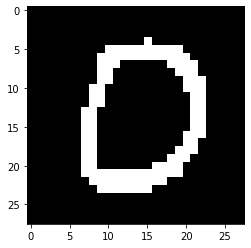

In [ ]:
test_img = test_dataset[10].detach().numpy()
plt.imshow(test_img, cmap="gray") 

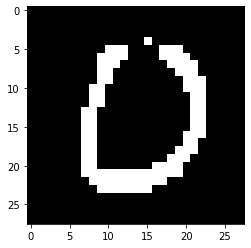

In [ ]:
X = 6
Y = 14
LEN = 4
remove_show(test_img, X, Y, LEN)

[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


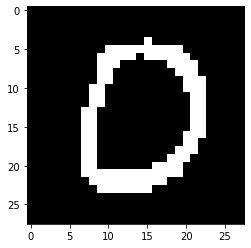

In [ ]:
# repair the image(inference)
ITERATION = 2

square = remove_square(X, Y, LEN)
a = 0.8484031283945034
b = 0.08936653859185303
c = 0.16849723279052853
a = torch.tensor(a,dtype=torch.float64)
b = torch.tensor(b,dtype=torch.float64)
c = torch.tensor(c,dtype=torch.float64)

graph = initialize(test_dataset[10], square)
infer_list = passing_infer(graph, square, a, b, c)
print(infer_list)

repair_image = repair(test_dataset[10].detach().numpy(), infer_list, X, Y, LEN)
plt.imshow(repair_image, cmap="gray") 


In [ ]:
def remove_show(image, x, y, len, image_size=28):
  for i in range(image_size):
    for j in range(image_size):
      if x<=(i+1)<=(x+len-1) and y<=(j+1)<=(y+len-1):
        image[i][j] = 0
  plt.imshow(image, cmap="gray") 


In [ ]:
def normalize_mes(graph):
  max_mes = 0
  min_mes = 1
  for id, edge in graph.edges.items():
    if torch.max(edge.messages) > max_mes:
      max_mes = torch.max(edge.messages)
      max_id = id
    if edge.messages[0][0]!=-1 and edge.messages[0][0]<min_mes:
      min_mes = edge.messages[0][0]
    if edge.messages[0][1]!=-1 and edge.messages[0][1]<min_mes:
      min_mes = edge.messages[0][1]
  # print(max_mes, max_id)
  # print(graph.edges[max_id].messages)
  for id, edge in graph.edges.items():
    if edge.messages[0][0] != -1:
      graph.edges[id].messages[0][0] = edge.messages[0][0]/max_mes
    if edge.messages[0][1] != -1:
      graph.edges[id].messages[0][1] = edge.messages[0][1]/max_mes
    # print(graph.edges[id].messages)
    
  return graph